In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
products_df = pd.read_csv('./data/feature_frame.csv')

In [3]:
def get_relevant_orders_df(df: pd.DataFrame, num_orders: int) -> pd.DataFrame:
    """We get the orders that have more or equal than num_orders products bought"""
    bought_products = df.query('outcome == 1')
    orders_relevants = bought_products.groupby('order_id')['variant_id'].agg(lambda x: len(list(x))).reset_index().query(f'variant_id >= {num_orders}')
    return df.merge(orders_relevants[['order_id']], on='order_id')

In [4]:
filtered_df = get_relevant_orders_df(products_df, 5)

In [5]:
print(f"Original number of orders: {products_df['order_id'].nunique()}")
print(f"Orders bigger or equal than 5: {filtered_df['order_id'].nunique()}")

Original number of orders: 3446
Orders bigger or equal than 5: 2603


In [6]:
filtered_df['order_date'] = pd.to_datetime(filtered_df['order_date']).dt.date
filtered_df['created_at'] = pd.to_datetime(filtered_df['created_at'])

In [7]:
info_cols = ['variant_id','order_id','user_id',"created_at","order_date"]

count_cols = ['count_adults', 'count_children',
       'count_babies', 'count_pets', 'people_ex_baby']

categorical_cols = ['vendor', 'product_type']

In [8]:
filtered_df[categorical_cols].nunique()

vendor          264
product_type     62
dtype: int64

- Id and date columns are not used for the prediction, so we drop them.
- Count columns are unreliable since the majority of the data were non-existent and were imputed with the mean as we saw at the EDA. We drop them.
- Categorical cols are not used in the model, due to the amount of cardinality. We drop them.

In [9]:
X = filtered_df.drop(['outcome']+info_cols+categorical_cols+count_cols, axis=1)
Y = filtered_df['outcome']

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2163953 entries, 0 to 2163952
Data columns (total 14 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   user_order_seq                    int64  
 1   ordered_before                    float64
 2   abandoned_before                  float64
 3   active_snoozed                    float64
 4   set_as_regular                    float64
 5   normalised_price                  float64
 6   discount_pct                      float64
 7   global_popularity                 float64
 8   days_since_purchase_variant_id    float64
 9   avg_days_to_buy_variant_id        float64
 10  std_days_to_buy_variant_id        float64
 11  days_since_purchase_product_type  float64
 12  avg_days_to_buy_product_type      float64
 13  std_days_to_buy_product_type      float64
dtypes: float64(13), int64(1)
memory usage: 231.1 MB


In [11]:
X_train, X_valtest, Y_train, Y_valtest = train_test_split(X, Y, test_size=0.7, random_state=15,shuffle=False)
X_val, X_test, Y_val, Y_test = train_test_split(X_valtest, Y_valtest, test_size=0.5, random_state=15,shuffle=False)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [12]:
def plot_roc__pr_curves(model_name:str,y_pred: pd.Series,y_test:pd.Series, 
                        figure = None):
     
    precision,recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

      
    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    else:
        fig,ax = figure
        
        
    ax[0].plot(recall, precision, label=f"{model_name} AUC: {pr_auc}")
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')
    ax[0].set_title('Precision-Recall curve')
    ax[0].legend()
    
    ax[1].plot(fpr, tpr, label=f"{model_name} AUC: {roc_auc}")
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('ROC curve')
    ax[1].legend()

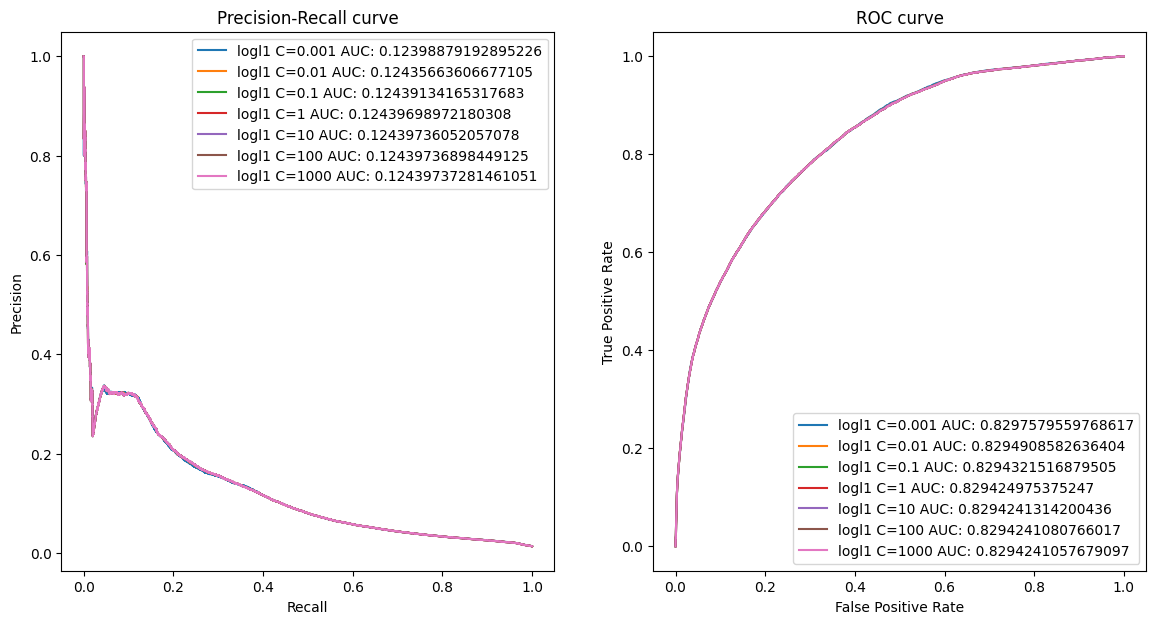

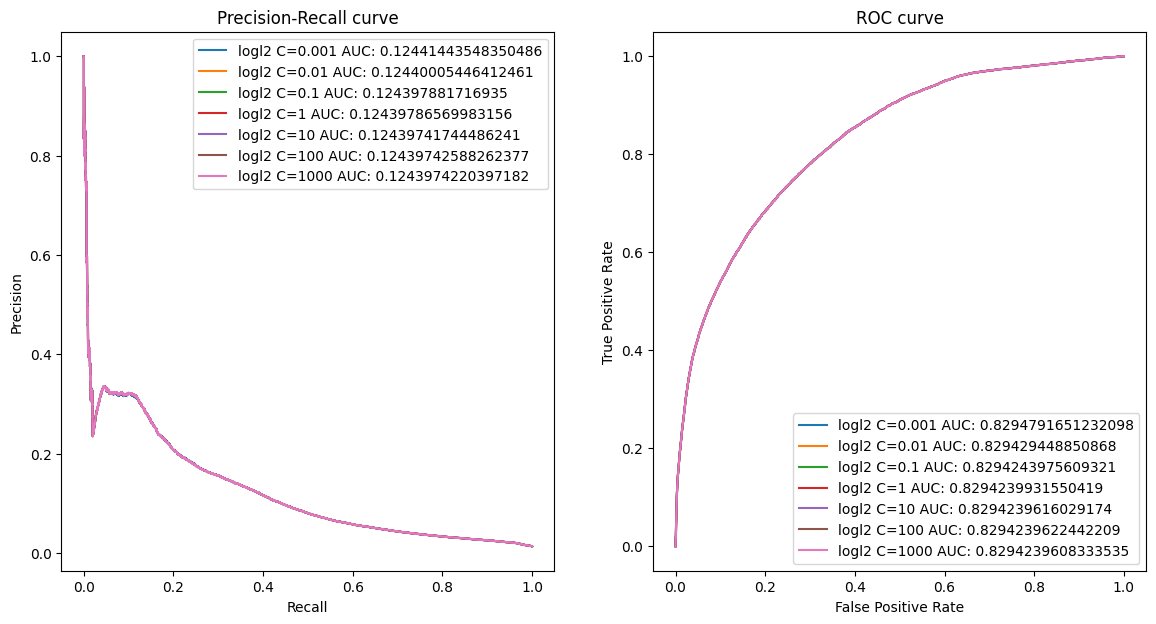

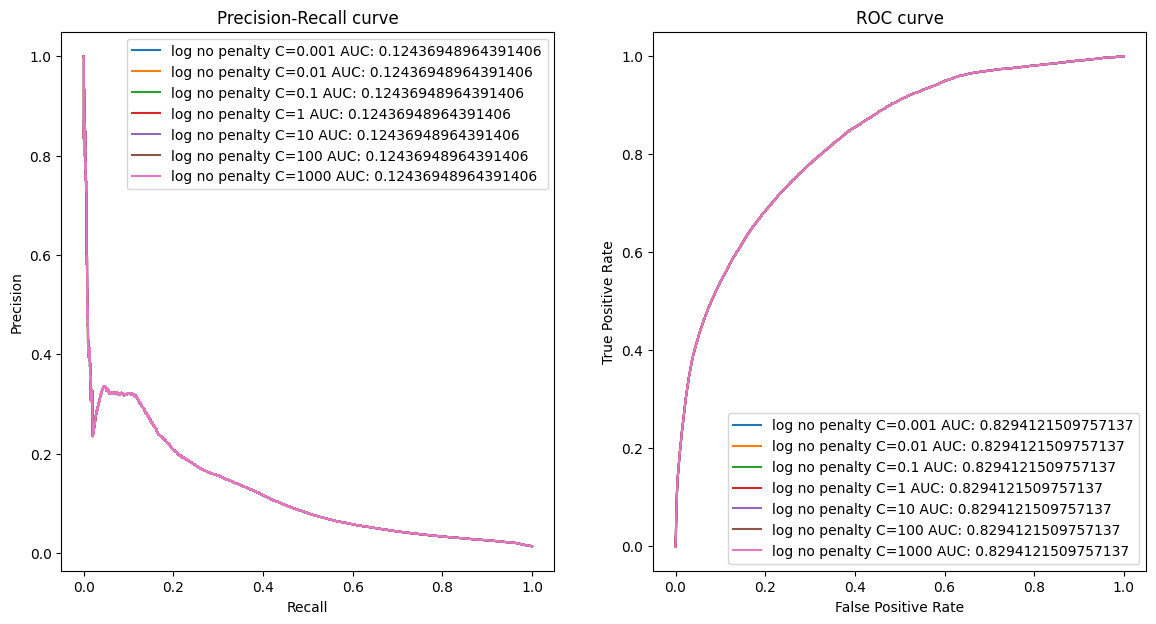

In [13]:
params = {
    'C': [0.001,0.01, 0.1, 1, 10, 100,1000]
}

fig1,ax1 = plt.subplots(1,2,figsize=(14,7))
fig2,ax2 = plt.subplots(1,2,figsize=(14,7))
fig3,ax3 = plt.subplots(1,2,figsize=(14,7))

for c in params['C']:
    
    log_l1 = LogisticRegression(class_weight='balanced',solver='liblinear',penalty='l1',C=c ,random_state=15)
    log_l1.fit(X_train,Y_train)
    predicts = log_l1.predict_proba(X_val)[:,1]
    plot_roc__pr_curves(f"logl1 C={c}",y_pred = predicts,y_test = Y_val,figure=(fig1,ax1))

    log_l2 = LogisticRegression(class_weight='balanced',solver='liblinear',C=c,penalty='l2',random_state=15)
    log_l2.fit(X_train,Y_train)
    predicts = log_l2.predict_proba(X_val)[:,1]
    plot_roc__pr_curves(f"logl2 C={c}",y_pred = predicts,y_test = Y_val,figure=(fig2,ax2))
    
    log_no = LogisticRegression(class_weight='balanced',penalty=None,random_state=15)
    log_no.fit(X_train,Y_train)
    predicts = log_no.predict_proba(X_val)[:,1]
    plot_roc__pr_curves(f"log no penalty C={c}",y_pred = predicts,y_test = Y_val,figure=(fig3,ax3))


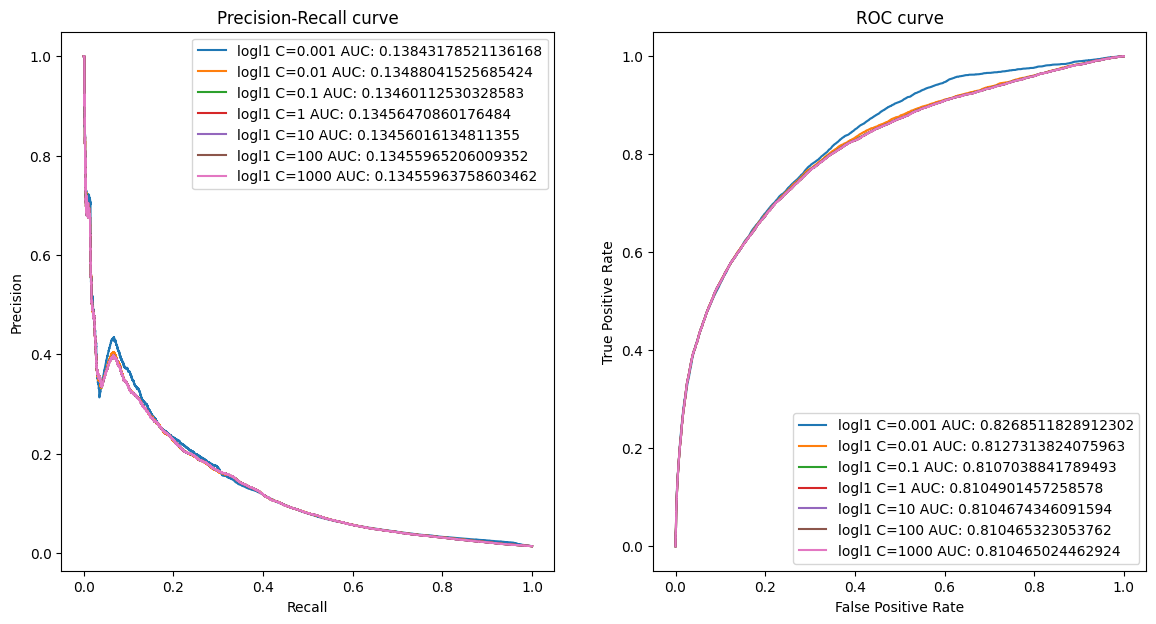

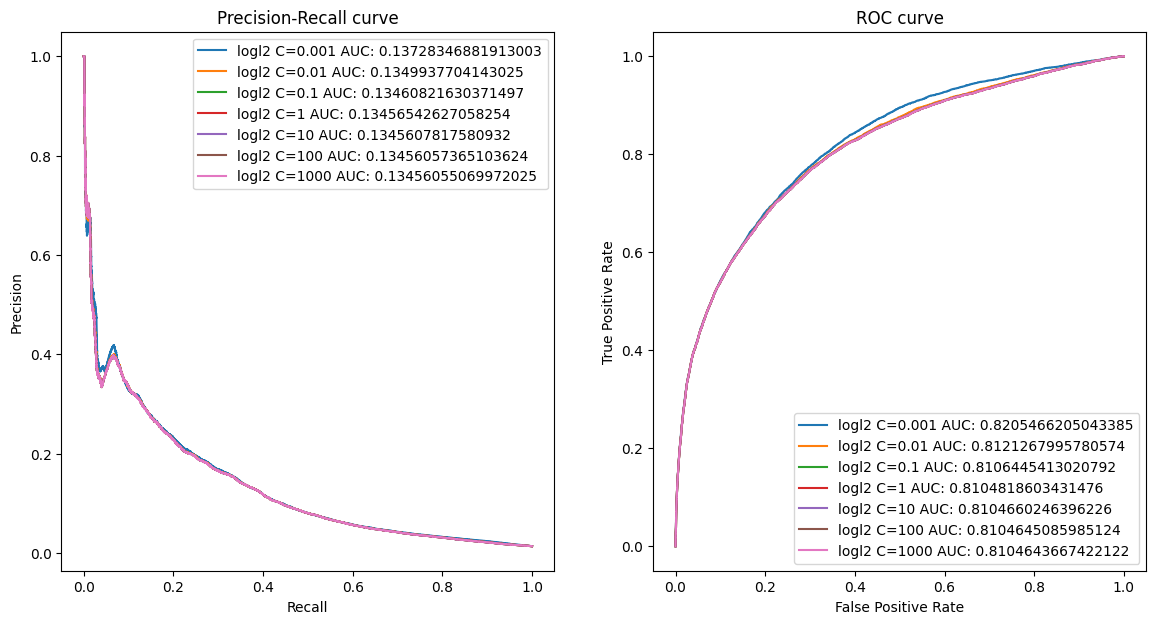

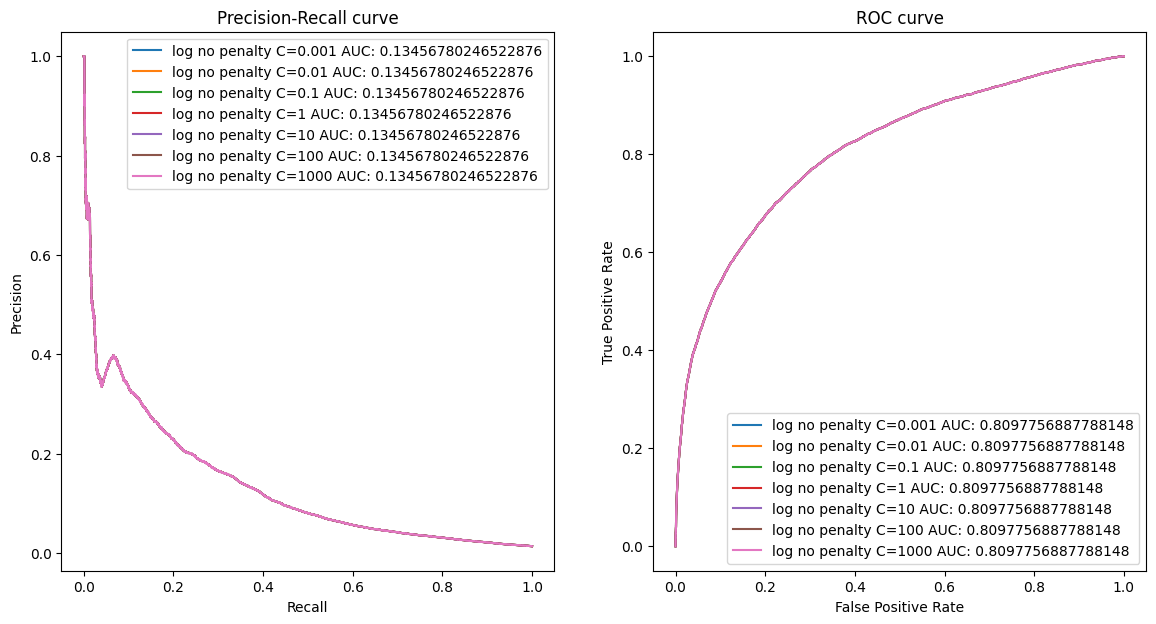

In [14]:
params = {
    'C': [0.001,0.01, 0.1, 1, 10, 100,1000]
}

fig1,ax1 = plt.subplots(1,2,figsize=(14,7))
fig2,ax2 = plt.subplots(1,2,figsize=(14,7))
fig3,ax3 = plt.subplots(1,2,figsize=(14,7))

for c in params['C']:
    
    log_l1 = LogisticRegression(solver='liblinear',penalty='l1',C=c ,random_state=15)
    log_l1.fit(X_train,Y_train)
    predicts = log_l1.predict_proba(X_val)[:,1]
    plot_roc__pr_curves(f"logl1 C={c}",y_pred = predicts,y_test = Y_val,figure=(fig1,ax1))

    log_l2 = LogisticRegression(solver='liblinear',C=c,penalty='l2',random_state=15)
    log_l2.fit(X_train,Y_train)
    predicts = log_l2.predict_proba(X_val)[:,1]
    plot_roc__pr_curves(f"logl2 C={c}",y_pred = predicts,y_test = Y_val,figure=(fig2,ax2))
    
    log_no = LogisticRegression(penalty=None,random_state=15)
    log_no.fit(X_train,Y_train)
    predicts = log_no.predict_proba(X_val)[:,1]
    plot_roc__pr_curves(f"log no penalty C={c}",y_pred = predicts,y_test = Y_val,figure=(fig3,ax3))

- Models with balanced class weights show slightly worse results than unbalanced models in the Precision-Recall curve, in the case of the ROC curve it is the opposite case with slightly better values.
- At weight balanced models, we see no difference between models with most regularization and models with least regularization.
- At nonbalanced models, model with most regularization show slightly better results -> C= 0.001

We won't use class weights balanced models since the parameter 'class_weight=balanced' is removing the importance of the penalty type and the value of C and we cannot make a study of the coefficients.

In [15]:
log_l1 = LogisticRegression(solver='liblinear',C=0.001,penalty='l1')
log_l1.fit(X_train,Y_train)

log_l2 = LogisticRegression(solver='liblinear',C=0.001,penalty='l2')
log_l2.fit(X_train,Y_train)

LogisticRegression(C=0.001, solver='liblinear')

In [16]:
lr1_coef = pd.DataFrame({'feature':X.columns,
                          'coeff':np.abs(log_l1.coef_[0]),
                          'regularization':["L1"] * len(X.columns)}).sort_values('coeff',ascending=False)

lr2_coef = pd.DataFrame({'feature':X.columns,
                           'coeff':np.abs(log_l2.coef_[0]),
                           'regularization':["L2"] * len(X.columns)}).sort_values('coeff',ascending=False)

<Axes: xlabel='coeff', ylabel='feature'>

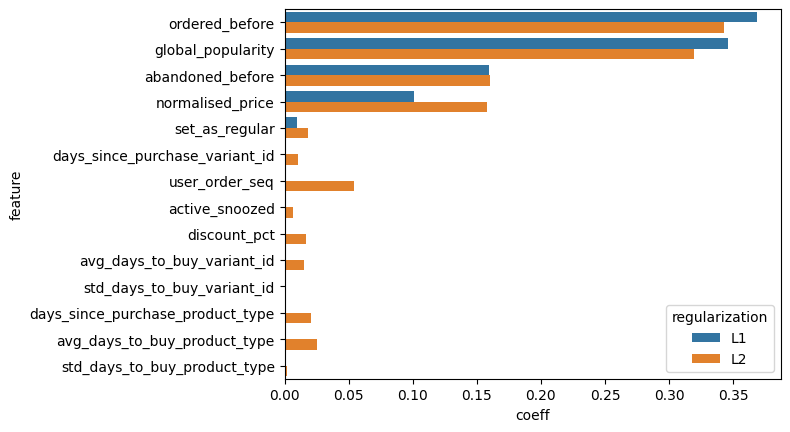

In [17]:
lr_coeffs = pd.concat([lr1_coef,lr2_coef]).reset_index(drop=True)

sns.barplot(data=lr_coeffs,x='coeff',y='feature',hue='regularization')

### Trying the model with reduced number of features

In [18]:
most_important_features = ['global_popularity','ordered_before','abandoned_before','normalised_price']

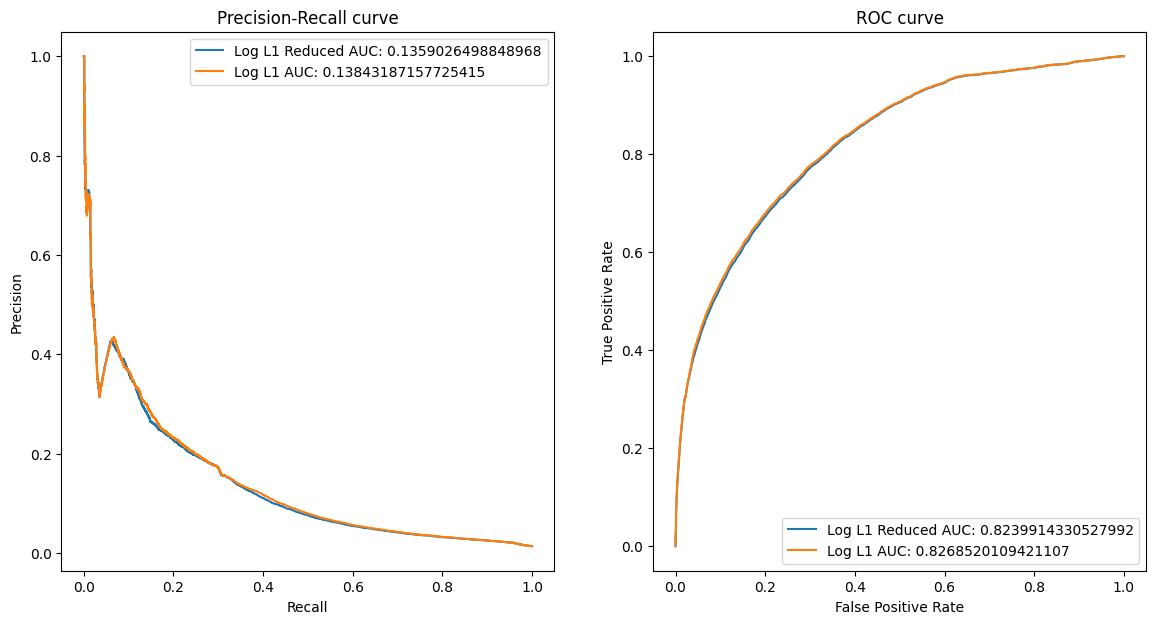

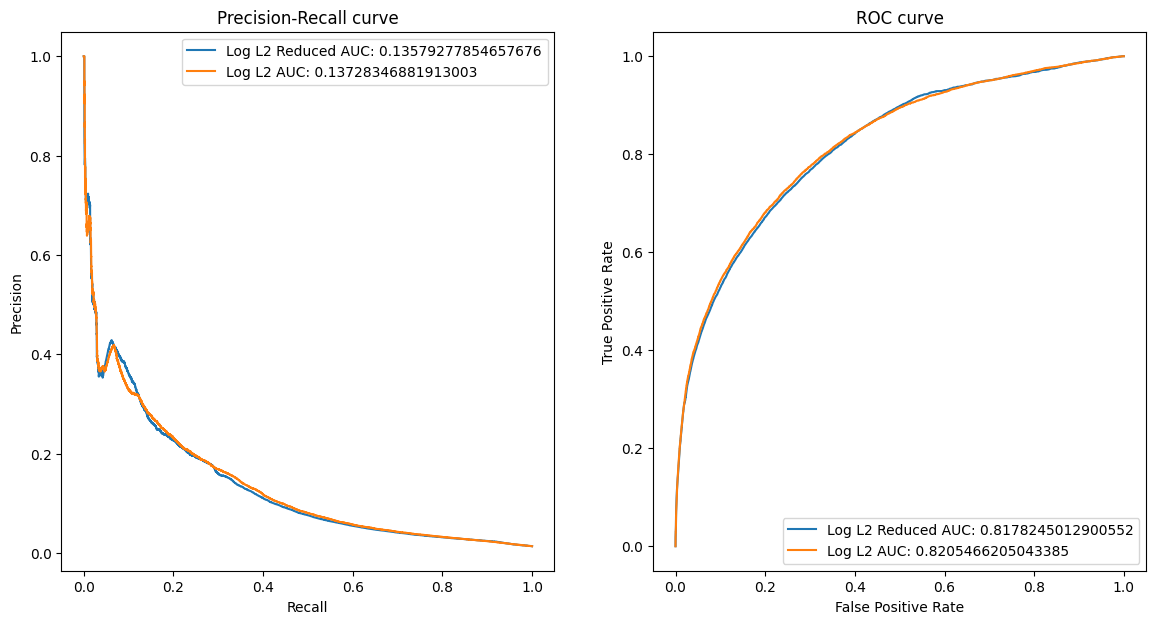

In [19]:
fig1,ax1 = plt.subplots(1,2,figsize=(14,7))

fig2,ax2 = plt.subplots(1,2,figsize=(14,7))

log_l1_reduced = LogisticRegression(solver='liblinear',
                                    C=0.001,
                                    penalty='l1',
                                    random_state=15)

log_l1_reduced.fit(X_train[:,X.columns.isin(most_important_features)],Y_train)

plot_roc__pr_curves("Log L1 Reduced",log_l1_reduced.predict_proba(X_val[:,X.columns.isin(most_important_features)])[:,1],Y_val,figure=(fig1,ax1))
plot_roc__pr_curves("Log L1",log_l1.predict_proba(X_val)[:,1],Y_val,figure=(fig1,ax1))

log_l2_reduced = LogisticRegression(solver='liblinear',
                                    C=0.001,
                                    penalty='l2',
                                    random_state=15)
log_l2_reduced.fit(X_train[:,X.columns.isin(most_important_features)],Y_train)

plot_roc__pr_curves("Log L2 Reduced",log_l2_reduced.predict_proba(X_val[:,X.columns.isin(most_important_features)])[:,1],Y_val,figure=(fig2,ax2))
plot_roc__pr_curves("Log L2",log_l2.predict_proba(X_val)[:,1],Y_val,figure=(fig2,ax2))

- We can see the difference between the models with all features and the models with reduced number of features are minimal, the reduced model performs almost as well as the full model.
- This can make us think about using this model, since we can have the same performance, with a more efficient model that allows us to have more interpretability.
- Also for production use it is important that the model can be used without waiting times so a reduction of the variables is good.